# 🫁 Pneumonia Detection using CNN on Chest X-Ray Images

## 1. Overview
In this project, we apply Convolutional Neural Networks (CNN) to classify chest X-ray images into *Pneumonia* and *Normal* categories.

**About the Dataset**
- Pediatric chest X-ray images (ages 1–5).
- Two classes: **Pneumonia** and **Normal**.
- More info: [link](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5).

**Tasks**

- Load dataset from `DATA_PATH`  
- Visualize samples from each class  
- Compute dataset statistics (e.g. number of images per class)  
- Prepare `DataLoader` for training/validation/testing

In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

# record start time
_START_RUNTIME = time.time()

# set seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

# Define data and weight path

DATA_PATH = "data1/data"
WEIGHT_PATH = "data1/resnet18_weights_9.pth"

In [2]:
def get_count_metrics(folder, data_path=DATA_PATH):
    '''
    This function returns the number of NORMAL and PNEUMONIA samples
    in the specified folder (train, val, or test).
    '''
    number_pneumonia = len(os.listdir(f"{data_path}/{folder}/PNEUMONIA"))
    number_normal = len(os.listdir(f"{data_path}/{folder}/NORMAL"))

    return number_normal, number_pneumonia


def load_data(data_path=DATA_PATH):
    '''
    This function loads training and validation datasets using ImageFolder.
    Transforms applied:
      - RandomResizedCrop(224,224)
      - ToTensor()
    Returns DataLoader objects for train and validation sets.
    '''
    import torchvision
    import torchvision.datasets as datasets
    import torchvision.transforms as transforms
    
    transform = transforms.Compose([
        transforms.RandomResizedCrop((224, 224)),
        transforms.ToTensor()]
    )
    
    train_dataset = datasets.ImageFolder(
        root=f"{data_path}/train",
        transform=transform
    )
    # validation dataset
    valid_dataset = datasets.ImageFolder(
        root=f"{data_path}/val",
        transform=transform
    )
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=32, shuffle=True
    )
    # validation data loaders
    val_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=32, shuffle=False
    )
    
    return train_loader, val_loader


In [3]:
print("Type of train count metrics:", type(get_count_metrics('train')))
print("Type of val count metrics:  ", type(get_count_metrics('val')))

train_normal, train_pneumonia = get_count_metrics('train')
val_normal, val_pneumonia = get_count_metrics('val')

print("\n===== Dataset Statistics =====")
print(f"Train Set  -> Normal: {train_normal}, Pneumonia: {train_pneumonia}")
print(f"Val Set    -> Normal: {val_normal}, Pneumonia: {val_pneumonia}")
 

Type of train count metrics: <class 'tuple'>
Type of val count metrics:   <class 'tuple'>

===== Dataset Statistics =====
Train Set  -> Normal: 335, Pneumonia: 387
Val Set    -> Normal: 64, Pneumonia: 104


In [4]:
train_loader, val_loader = load_data()

print("=== DataLoader Information ===")
print(f"Type of train_loader: {type(train_loader)}")
print(f"Type of val_loader:   {type(val_loader)}")

print("\n=== Number of Batches ===")
print(f"Train Loader Batches: {len(train_loader)}")
print(f"Val Loader Batches:   {len(val_loader)}")

=== DataLoader Information ===
Type of train_loader: <class 'torch.utils.data.dataloader.DataLoader'>
Type of val_loader:   <class 'torch.utils.data.dataloader.DataLoader'>

=== Number of Batches ===
Train Loader Batches: 23
Val Loader Batches:   6


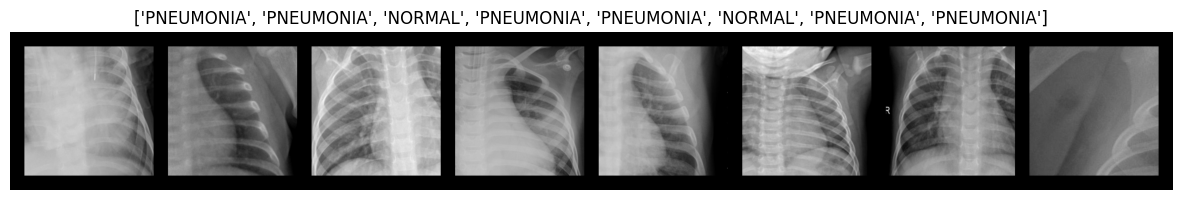

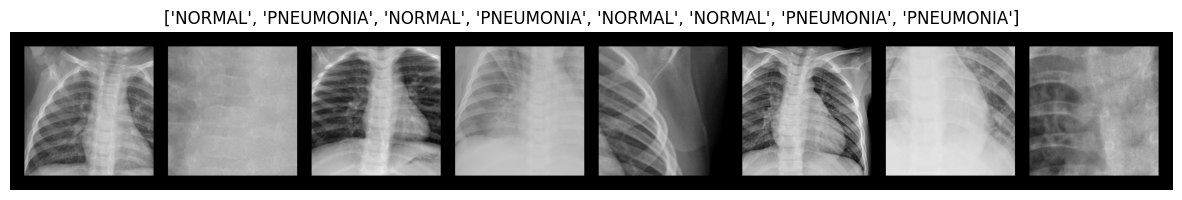

In [5]:
import torchvision
import matplotlib.pyplot as plt

def imshow(img, title):
    npimg = img.numpy()
    plt.figure(figsize=(15, 7))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

def show_batch_images(dataloader, k=8):
    images, labels = next(iter(dataloader))
    images = images[:k]
    labels = labels[:k]
    img = torchvision.utils.make_grid(images, padding=25)
    imshow(img, title=["NORMAL" if x==0  else "PNEUMONIA" for x in labels])

train_loader, val_loader = load_data()   
for i in range(2):
    show_batch_images(train_loader)

## 2. Build the Model

In this section, we define a Convolutional Neural Network (CNN) to classify chest X-ray images as **Normal** or **Pneumonia**. Unlike MLPs that use only fully-connected layers, CNNs leverage:

- **Convolutional Layers:** extract features by applying learnable filters.
- **ReLU Activation:** adds non-linearity to the network.
- **MaxPooling Layers:** reduce spatial dimensions while keeping the most important features.
- **Fully-Connected + Dropout Layers:** produce the final 2-class output and help prevent overfitting.


In [6]:
def conv_output_volume(W, F, S, P):
    """
    Calculate the output size of a convolutional layer.

    Parameters:
    W : int - input volume size (height/width)
    F : int - filter/kernel size
    S : int - stride
    P : int - padding
 
    """
    return int(np.floor((W + 2*P - F) / S) + 1)


In [7]:
# Example
W_out = conv_output_volume(W=224, F=3, S=1, P=1)
print("Output size:", W_out)

Output size: 224


### Define CNN

We define a small CNN to classify chest X-ray images as **Normal** or **Pneumonia**.  

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    """
    Simple CNN for classifying chest X-ray images into Normal / Pneumonia.
    Architecture:
      3 Conv layers + ReLU + MaxPooling
      Fully-Connected + Dropout → Output (2 classes)
    """
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        
        # Convolutional layers
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # Conv1
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # Conv2
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # Conv3
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.25),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.classifier(x)
        return x

# Example initialization
model = SimpleCNN()
print(model)


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=100352, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=512, out_features=2, bias=True)
  )
)


In [9]:
simple_model = SimpleCNN()
simple_model_size = sum([param.nelement() * param.element_size() for param in simple_model.parameters()]) / 1e9
print('SimpleCNN size in GB:', simple_model_size)


SimpleCNN size in GB: 0.20590004


In [10]:
simple_model = SimpleCNN()

print("Is SimpleCNN a subclass of nn.Module?", issubclass(type(simple_model), nn.Module))
print("Number of modules in the model:", len(list(simple_model.modules())))

test_input = torch.zeros(32, 3, 224, 224) 
test_output = simple_model(test_input)
print("Output shape:", test_output.shape)


Is SimpleCNN a subclass of nn.Module? True
Number of modules in the model: 16
Output shape: torch.Size([32, 2])


- **Using Predefined CNN Model**

In [11]:
def get_cnn_model():
    """
    Define a ResNet18 CNN model for binary classification (Normal / Pneumonia).
    
    Steps:
    1. Load ResNet18 (pretrained=False)
    2. Replace the final fc layer with nn.Linear(input_size, 2)
    3. Freeze all layers except the last fc layer
    """
    from torchvision import models
    import torch.nn as nn
    
    num_classes = 2
    # Load ResNet18
    model = models.resnet18(pretrained=False)
    
    # Replace the final fully connected layer
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    
    # Freeze all layers except the final fc
    for name, param in model.named_parameters():
        if name.startswith('fc'):
            param.requires_grad = True
        else:
            param.requires_grad = False
    
    return model

# Example usage
resnet_model = get_cnn_model()
print(resnet_model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

c:\Users\New\.conda\envs\gpu_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\New\.conda\envs\gpu_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [12]:
# Instantiate the model
model = get_cnn_model()

print("Is model a subclass of nn.Module?", issubclass(type(model), nn.Module))
print("Number of modules in the model:", len(list(model.modules())))
print("Number of parameters in the model:", len(list(model.parameters())))


Is model a subclass of nn.Module? True
Number of modules in the model: 68
Number of parameters in the model: 62


- **Training the Network**

In [13]:
model = get_cnn_model()

#Load the pretrained weights
model.load_state_dict(torch.load(WEIGHT_PATH, map_location='cpu'))

C:\Users\New\AppData\Local\Temp\ipykernel_30304\34496628.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(WEIGHT_PATH, map_location='cpu'

<All keys matched successfully>

- **Criterion and Opimizer**

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)


- **Training**

To train the CNN:

1. **Zero Gradients:** `optimizer.zero_grad()`  
2. **Forward Pass:** Compute predictions  
3. **Compute Loss:** Compare predictions with targets  
4. **Backward Pass:** `loss.backward()` to calculate gradients  
5. **Optimizer Step:** `optimizer.step()` to update parameters  
6. **Track Metrics:** Update average loss (and optionally accuracy)

Repeat for all batches and epochs until convergence.


In [15]:
import numpy as np
import torch

n_epochs = 5  # number of epochs

def train_model(model, train_dataloader, n_epoch=n_epochs, optimizer=optimizer, criterion=criterion):
    """
    Train a CNN model.

    :param model: CNN model
    :param train_dataloader: DataLoader for training data
    :param n_epoch: number of epochs
    :param optimizer: optimizer for model parameters
    :param criterion: loss function
    :return: trained model
    """
    model.train()  # set model to training mode

    for epoch in range(n_epoch):
        curr_epoch_loss = []

        for data, target in train_dataloader:
            # Forward pass
            output = model(data)
            
            # Compute loss
            loss = criterion(output, target)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            curr_epoch_loss.append(loss.item())

        print(f"Epoch {epoch+1}/{n_epoch}: Average Loss = {np.mean(curr_epoch_loss):.4f}")

    return model


In [16]:
# get train and val data loader
train_loader, val_loader = load_data()
model = train_model(model, train_loader)

Epoch 1/5: Average Loss = 0.2094
Epoch 2/5: Average Loss = 0.1967
Epoch 3/5: Average Loss = 0.2058
Epoch 4/5: Average Loss = 0.1915
Epoch 5/5: Average Loss = 0.1773


- **Test the Trained Network**

In [17]:
def eval_model(model, dataloader):
    """
    Evaluate a CNN model on a dataloader.

    Returns:
        Y_pred: numpy array of shape (n_samples, 2) with model outputs (logits)
        Y_test: numpy array of true labels (ints)
    """
    model.eval()
    Y_pred, Y_test = [], []
    for data, target in dataloader:
        output = model(data)
        _, pred = torch.max(output, dim=1)
        Y_pred.append(pred.numpy())
        Y_test.append(target.numpy())
            
    Y_pred = np.concatenate(Y_pred, axis=0)
    Y_test = np.concatenate(Y_test, axis=0)

    return Y_pred, Y_test


In [18]:
from sklearn.metrics import accuracy_score

y_pred, y_true = eval_model(model, val_loader)
acc = accuracy_score(y_true, y_pred)
print(("Validation Accuracy: " + str(acc)))
print("Total running time = {:.2f} seconds".format(time.time() - _START_RUNTIME))

Validation Accuracy: 0.8511904761904762
Total running time = 95.92 seconds
